In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import analysis.plotting as plotting
import analysis.analysis as analysis
import hardware_control.vna_analysis as vna
import hardware_control.keithley as keithley
import hardware_control.bnc as bnc


In [2]:
keithley_address = 'GPIB0::24::INSTR'
# keithley_current=2.18
# keithley.set_current(keithley_address, keithley_current, step_size_mA=0.01)

In [13]:
target_bnc_address = "USB0::0x03EB::0xAFFF::471-43A6D0000-1458::INSTR"
bnc.set_bnc_output(5.1,-4.4, bnc_addr=target_bnc_address)

In [4]:
def run_initial_trace(current:float):
    keithley.set_current(keithley_address, current, step_size_mA=0.01)
    time.sleep(7)
    sdata = vna.get_smith_data(restart_average=False)
    freqs = sdata.freqs
    real_part = sdata.real
    imag_part = sdata.imag
    lin_mag = sdata.lin_mag
    log_mag = sdata.log_mag
    return freqs, log_mag

def run_current_sweep(start_current=1.8,stop_current=2.5,num_points=41,sweep_steps=501):
    sweep_vals = np.linspace(start_current, stop_current, num_points)
    log_mag=np.zeros( ( num_points, sweep_steps))
    phase_deg=np.zeros( (num_points, sweep_steps))
    for i,ss in enumerate(sweep_vals):
        keithley.set_current(keithley_address, ss, step_size_mA=0.01)
        time.sleep(5)
        sdata = vna.get_smith_data(restart_average=False)
        freqs = sdata.freqs
        log_mag[i] = sdata.log_mag
        phase_deg[i] = sdata.phase_deg
    plt.imshow(log_mag, extent=[4,8,stop_current,start_current],aspect='auto' )
    plt.show()
    plt.imshow(phase_deg, extent=[4,8,stop_current,start_current],aspect='auto' )
    plt.show()
    return log_mag,phase_deg

def run_pump_sweep(start_freq =7,stop_freq = 9,freq_step = .05,start_pow = 2,stop_pow = -8,pow_step =.2):
    num_freq = abs(int((stop_freq-start_freq)/freq_step))+1
    num_pow = abs(int((stop_pow-start_pow)/pow_step))+1
    pow_list = np.linspace(start_pow, stop_pow, num_pow)
    freq_list = np.linspace(start_freq, stop_freq, num_freq)
    average_mag = np.zeros( ( num_freq, num_pow))
    average_log_mag=np.zeros( ( num_freq, num_pow))
    time.sleep(4)
    centers = [6.72736, 6.65544, 6.58374, 6.51117, 6.44418]
    window = 0.01  # GHz
    half_window = window / 2
    for i, freq in enumerate(freq_list):
        for j, power in enumerate(pow_list):
            bnc.set_bnc_output(freq, power, bnc_addr=target_bnc_address)
            time.sleep(4)
            sdata = vna.get_smith_data()
            freqs = sdata.freqs/1e9
            log_mag = sdata.log_mag
            average_log_mag[i,j]=np.mean(log_mag)
            # Collect mean values for each window
            means = []
            for center in centers:
                indices = np.where((freqs >= center - half_window) & (freqs <= center + half_window))[0]
                means.append(np.mean(log_mag[indices]))
            average_mag[i, j] = np.mean(means)
            print("freq=",freq,"power=",power,"average_ro=",np.mean(means),"average_tot=",np.mean(log_mag))

            # plt.plot(freqs, log_mag)
            # plt.show()
    
    return average_mag,average_log_mag

def run_gain_profile(freq = 4.5,amp = -5.4):
    bnc.set_bnc_output(freq,amp, bnc_addr=big_agilent_address)
    time.sleep(10)
    sdata = vna.get_smith_data()
    freqs = sdata.freqs
    log_mag= sdata.log_mag
    return freqs,log_mag

In [5]:
start_freq =4
stop_freq = 9
freq_step = 0.05
start_pow = 2
stop_pow = -8
pow_step =0.2
num_freq = abs(int((stop_freq-start_freq)/freq_step))+1
num_pow = abs(int((stop_pow-start_pow)/pow_step))+1
pow_list = np.linspace(start_pow, stop_pow, num_pow)
freq_list = np.linspace(start_freq, stop_freq, num_freq)
average_mag,average_log_mag=run_pump_sweep(start_freq,stop_freq,freq_step,start_pow,stop_pow,pow_step)


freq= 4.0 power= 2.0 average_ro= -89.48467341949784 average_tot= -89.47335246055707
freq= 4.0 power= 1.8 average_ro= -89.52068058944948 average_tot= -88.8381254047916
freq= 4.0 power= 1.6 average_ro= -87.94492862669111 average_tot= -88.63533871469197
freq= 4.0 power= 1.4 average_ro= -88.38945285177176 average_tot= -89.20587854679115
freq= 4.0 power= 1.2 average_ro= -88.90897700937055 average_tot= -88.45896350209155
freq= 4.0 power= 1.0 average_ro= -88.21564183768135 average_tot= -88.86455780991875
freq= 4.0 power= 0.7999999999999998 average_ro= -89.38885116664112 average_tot= -88.7668762065774
freq= 4.0 power= 0.5999999999999999 average_ro= -88.92570257670748 average_tot= -88.98015106314921
freq= 4.0 power= 0.3999999999999999 average_ro= -89.14197185856781 average_tot= -89.17869767440055
freq= 4.0 power= 0.19999999999999996 average_ro= -89.71223197745121 average_tot= -89.32044726329184
freq= 4.0 power= 0.0 average_ro= -88.1140410913085 average_tot= -89.01313112563226
freq= 4.0 power= -

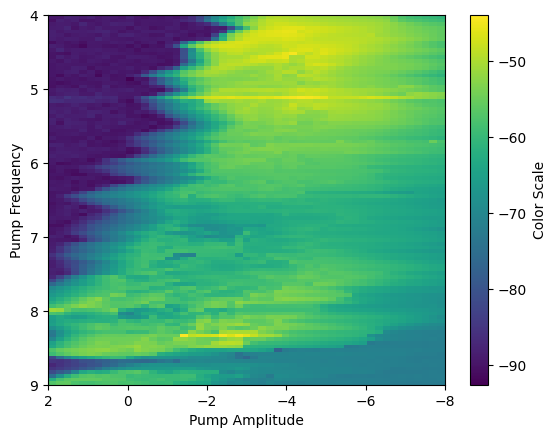

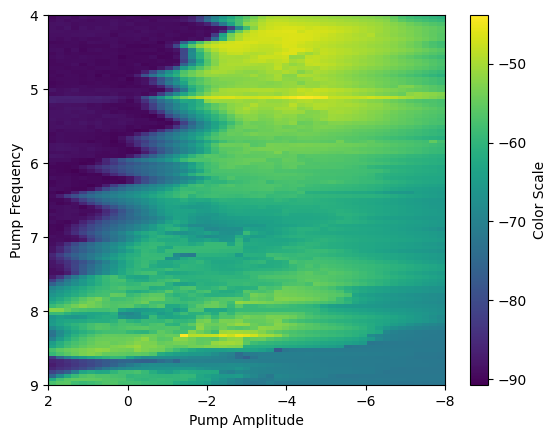

8.350000000000001
-1.4000000000000004
-43.96189162568752


In [6]:
plt.imshow(average_mag, extent=[start_pow,stop_pow,stop_freq,start_freq],aspect='auto' )
plt.colorbar(label='Color Scale')
plt.ylabel("Pump Frequency")
plt.xlabel("Pump Amplitude")
plt.show()
plt.imshow(average_log_mag, extent=[start_pow,stop_pow,stop_freq,start_freq],aspect='auto' )
plt.colorbar(label='Color Scale')
plt.ylabel("Pump Frequency")
plt.xlabel("Pump Amplitude")
plt.show()
max_index_mag = np.unravel_index(np.argmax(average_mag),average_mag.shape)
print(freq_list[max_index_mag[0]])
print(pow_list[max_index_mag[1]])
print(average_mag[max_index_mag[0],max_index_mag[1]])

Maximum in 4-7 GHz region:
Frequency: 5.1
Amplitude: -4.4
Value: -44.257065854186614


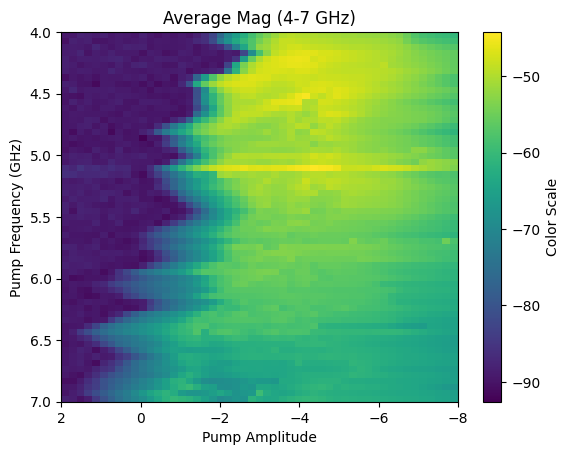

In [12]:
freq_mask = (freq_list >= 4) & (freq_list <= 7)
sub_mag = average_mag[freq_mask, :]
max_index_sub = np.unravel_index(np.argmax(sub_mag), sub_mag.shape)
freq_indices = np.where(freq_mask)[0]
real_freq_index = freq_indices[max_index_sub[0]]

print("Maximum in 4-7 GHz region:")
print("Frequency:", freq_list[real_freq_index])
print("Amplitude:", pow_list[max_index_sub[1]])
print("Value:", average_mag[real_freq_index, max_index_sub[1]])
sub_freqs = freq_list[freq_mask]
plt.imshow(
    sub_mag,
    extent=[pow_list[0], pow_list[-1], sub_freqs[-1], sub_freqs[0]],  # match axis order if needed!
    aspect='auto'
)
plt.colorbar(label='Color Scale')
plt.ylabel("Pump Frequency (GHz)")
plt.xlabel("Pump Amplitude")
plt.title("Average Mag (4-7 GHz)")
plt.show()

In [7]:
# freqs, log_mag=run_initial_trace(0)
# plt.plot(freqs,log_mag)

In [8]:
# start_current = 4
# stop_current = -4
# num_points = 51
# sweep_steps=200
# log_mag,phase_deg=run_current_sweep(start_current,stop_current,num_points,sweep_steps)

In [9]:
# plt.imshow(log_mag, extent=[4,8,stop_current,start_current],aspect='auto' )
# plt.axhline(2.18, color='black', linewidth=2,label="I=2.18")
# plt.axhline(-2.18, color='black', linewidth=2,label="I=-2.18")
# plt.legend()
# plt.ylabel("Bias curremt(mA)")
# plt.xlabel("Frequency")
# plt.title("Log_mag")
# plt.show()
# plt.imshow(phase_deg, extent=[4,8,stop_current,start_current],aspect='auto' )
# plt.axhline(2.18, color='black', linewidth=2,label="I=2.18")
# plt.axhline(-2.18, color='black', linewidth=2,label="I=2.18")
# plt.legend()
# plt.ylabel("Bias curremt(mA)")
# plt.xlabel("Frequency")
# plt.title("Phase_deg")
# plt.show()